In [1]:
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
import statsmodels.api as sm
from math import log10
from nltk.tokenize import RegexpTokenizer
import seaborn
seaborn.set()

/home/zwa117/sfuhome/cmpt-353/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
wiki = pd.read_json('wiki-company.json.gz', orient='record', lines=True)
rt = pd.read_json('rotten-tomatoes.json.gz', orient='record', lines=True)
omdb = pd.read_json('omdb-data.json.gz', orient='record', lines=True)

In [3]:
# drop NaN columns in 'nbox' and 'ncost'
wiki_dropNA = wiki.dropna(subset=['nbox', 'ncost', 'publication_date'])
# We want to get Profit by 'nbox' and 'ncost'
wiki_dropNA_box = wiki_dropNA[['nbox','ncost', 'publication_date','rotten_tomatoes_id']]

# we want to get only reviews from audiences and critics
rt_reviews = rt[['audience_average', 'audience_percent', 'audience_ratings', 'critic_average', 'critic_percent', 'rotten_tomatoes_id']]

# Merge (join) these two tables by common Rotten Tomatoes ID
wiki_join_rt = wiki_dropNA_box.merge(rt_reviews, left_on='rotten_tomatoes_id', right_on='rotten_tomatoes_id', suffixes=('_wiki', '_rt'))

In [4]:
# Calculate the profit (Or, loss if nbox < ncost)
wiki_join_rt['profit'] = wiki_join_rt['nbox'] - wiki_join_rt['ncost']

# Filter data a little bit. We just keep movies with more than 40 reviews (Discard very uncommon movies)
wiki_join_rt = wiki_join_rt[wiki_join_rt['audience_ratings']>=40]
wiki_join_rt = wiki_join_rt.dropna(subset=['critic_average', 'critic_percent'])

# Note that there are 817 movies remained, which is not bad though
# wiki_join_rt   # just have a look

In [5]:
# Inflation adjustment on the profit

def getyear(x):
    return x[0:4]

wiki_join_rt['year'] = wiki_join_rt['publication_date'].apply(getyear)
wiki_join_rt['year'] = pd.to_numeric(wiki_join_rt['year'])

# wiki_join_rt['year'].min()
# This shows the oldest movie comes from 1927
# Through the research on references, from 1927 to 2019, the value of US dollars has an inflation of 2.97% per year on average.
# We adjust this number according to year differences compared to 2019

def inflation_correct(x):
    year_difference = 2019 - wiki_join_rt['year']
    money_value = (1.0297) ** year_difference
    return x * money_value

wiki_join_rt['year_difference'] = 2019 - wiki_join_rt['year']
wiki_join_rt['money_value'] = (1.0297) ** wiki_join_rt['year_difference']
# wiki_join_rt['profit'] = wiki_join_rt['profit'].apply(inflation_correct)
# Calculate the "real" profit for each movie, based on its publication year and real value of money.
wiki_join_rt['profit'] = wiki_join_rt['profit']*wiki_join_rt['money_value']

# Do a correction on cost according to year as well:
wiki_join_rt['corr_ncost'] = wiki_join_rt['ncost']*wiki_join_rt['money_value']
wiki_join_rt['profit_rate'] = wiki_join_rt['profit'] / wiki_join_rt['corr_ncost']


In [24]:
wiki_join_rt.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 816 entries, 0 to 876
Data columns (total 16 columns):
nbox                  816 non-null float64
ncost                 816 non-null float64
publication_date      816 non-null object
rotten_tomatoes_id    816 non-null object
audience_average      816 non-null float64
audience_percent      816 non-null float64
audience_ratings      816 non-null float64
critic_average        816 non-null float64
critic_percent        816 non-null float64
profit                816 non-null float64
year                  816 non-null int64
year_difference       816 non-null int64
money_value           816 non-null float64
corr_ncost            816 non-null float64
profit_rate           816 non-null float64
prediction            816 non-null float64
dtypes: float64(12), int64(2), object(2)
memory usage: 108.4+ KB


4963602.191703152 -99452796.008239
6.931008046416733e-13
0.24767871552667778
0.06134474612494498


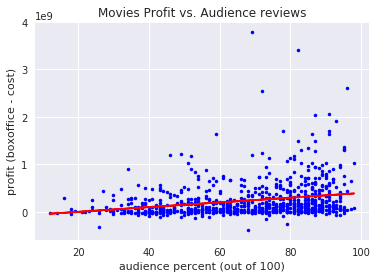

In [6]:
# Start to do the Linear Regression Models on these 3 variables (cirtic reviews / audience reviews / Profit): 

# audience reviews vs. profit
reg_audience = stats.linregress(wiki_join_rt['audience_percent'], wiki_join_rt['profit'])
plt.plot(wiki_join_rt['audience_percent'], wiki_join_rt['profit'],'b.')
plt.plot(wiki_join_rt['audience_percent'], reg_audience.slope*wiki_join_rt['audience_percent']+reg_audience.intercept, 'r-')
plt.title('Movies Profit vs. Audience reviews')
plt.xlabel('audience percent (out of 100)')
plt.ylabel('profit (boxoffice - cost)')

residuals_audience = wiki_join_rt['profit'] - (reg_audience.slope*wiki_join_rt['audience_percent'] + reg_audience.intercept)
print(reg_audience.slope, reg_audience.intercept)
print(reg_audience.pvalue)
print(reg_audience.rvalue)
print(reg_audience.rvalue**2)

(array([211., 467.,  97.,  26.,   9.,   3.,   2.,   0.,   1.,   1.]),
 array([-6.19100744e+08, -2.03240045e+08,  2.12620654e+08,  6.28481353e+08,
         1.04434205e+09,  1.46020275e+09,  1.87606345e+09,  2.29192415e+09,
         2.70778485e+09,  3.12364555e+09,  3.53950625e+09]),
 <a list of 10 Patch objects>)

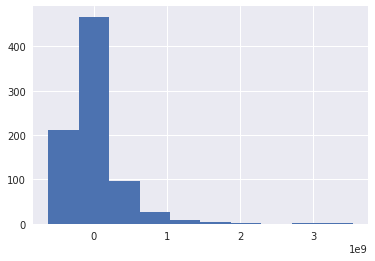

In [7]:
plt.hist(residuals_audience)

3388266.2845122963 19221161.71489668
1.1519241665977754e-11
0.2344581455653142
0.05497062202192606


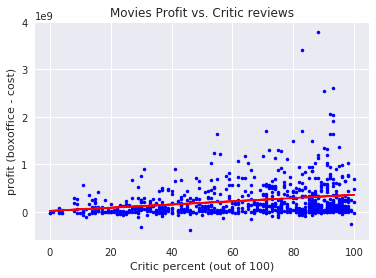

In [8]:
# critic reviews vs. profit
reg_critic = stats.linregress(wiki_join_rt['critic_percent'], wiki_join_rt['profit'])
plt.plot(wiki_join_rt['critic_percent'], wiki_join_rt['profit'],'b.')
plt.plot(wiki_join_rt['critic_percent'], reg_critic.slope*wiki_join_rt['critic_percent']+reg_critic.intercept, 'r-')
plt.title('Movies Profit vs. Critic reviews')
plt.xlabel('Critic percent (out of 100)')
plt.ylabel('profit (boxoffice - cost)')

residuals_critic = wiki_join_rt['profit'] - (reg_critic.slope*wiki_join_rt['critic_percent'] + reg_critic.intercept)
print(reg_critic.slope, reg_critic.intercept)
print(reg_critic.pvalue)
print(reg_critic.rvalue)
print(reg_critic.rvalue**2)

(array([231., 443.,  96.,  29.,   9.,   5.,   1.,   1.,   0.,   2.]),
 array([-6.04582513e+08, -1.97608921e+08,  2.09364671e+08,  6.16338263e+08,
         1.02331186e+09,  1.43028545e+09,  1.83725904e+09,  2.24423263e+09,
         2.65120622e+09,  3.05817982e+09,  3.46515341e+09]),
 <a list of 10 Patch objects>)

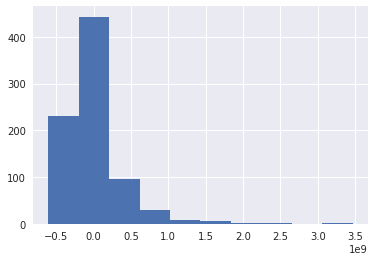

In [9]:
plt.hist(residuals_critic)

0.5770942170136605 30.701910573828116
3.268425159168612e-183
0.8002815315143735
0.6404505296829912


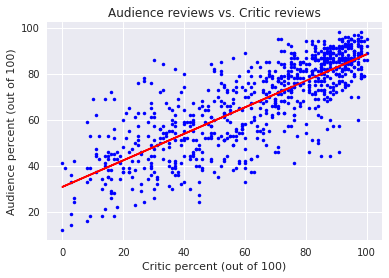

In [10]:
# audience reviews vs. critic reviews
reg_reviews = stats.linregress(wiki_join_rt['critic_percent'], wiki_join_rt['audience_percent'])
plt.plot(wiki_join_rt['critic_percent'], wiki_join_rt['audience_percent'],'b.')
plt.plot(wiki_join_rt['critic_percent'], reg_reviews.slope*wiki_join_rt['critic_percent']+reg_reviews.intercept, 'r-')
plt.title('Audience reviews vs. Critic reviews')
plt.xlabel('Critic percent (out of 100)')
plt.ylabel('Audience percent (out of 100)')

residuals_reviews = wiki_join_rt['audience_percent'] - (reg_reviews.slope*wiki_join_rt['critic_percent'] + reg_reviews.intercept)
print(reg_reviews.slope, reg_reviews.intercept)
print(reg_reviews.pvalue)
print(reg_reviews.rvalue)
print(reg_reviews.rvalue**2)

(array([  8.,  27.,  46., 119., 177., 256., 134.,  30.,  13.,   7.]),
 array([-37.48620167, -29.93905521, -22.39190875, -14.84476229,
         -7.29761584,   0.24953062,   7.79667708,  15.34382354,
         22.89097   ,  30.43811646,  37.98526292]),
 <a list of 10 Patch objects>)

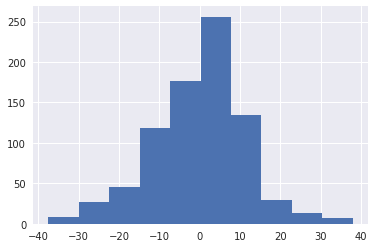

In [11]:
plt.hist(residuals_reviews)

In [12]:
rt_reviewsOnly = rt.drop(['rotten_tomatoes_id','imdb_id', 'audience_ratings'],axis=1)
rt_reviewsOnly.corr()

,audience_average,audience_percent,critic_average,critic_percent
audience_average,1.000000,0.902685,0.699100,0.668439
audience_percent,0.902685,1.000000,0.712904,0.687225
critic_average,0.699100,0.712904,1.000000,0.932374
critic_percent,0.668439,0.687225,0.932374,1.000000


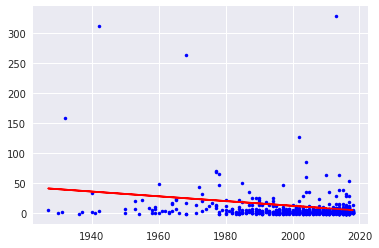

In [13]:
rate_fit = stats.linregress(wiki_join_rt['year'], wiki_join_rt['profit_rate'])
# blair_witch_project = wiki_join_rt[wiki_join_rt['profit_rate'] > 500]
# Actually, there's just 1 movie with super high rate of capitual return after the correction - "Blair Witch Project"
wiki_join_rt = wiki_join_rt[wiki_join_rt['profit_rate'] < 500]
wiki_join_rt['prediction'] = rate_fit.slope*wiki_join_rt['year'] + rate_fit.intercept
plt.plot(wiki_join_rt['year'], wiki_join_rt['profit_rate'], 'b.')
plt.plot(wiki_join_rt['year'], wiki_join_rt['prediction'],'r-')

****2. Sentiment Score (Q5)****

In [14]:
neg = open('negative-words.txt', 'r',encoding = "ISO-8859-1")
neg_lines = neg.readlines()
neg_lines = [x.replace('\n', '') for x in neg_lines]
# line_num = len(lines)
# print(lines)
# print(line_num)

pos = open('positive-words.txt', 'r',encoding = "ISO-8859-1")
pos_lines = pos.readlines()
pos_lines = [x.replace('\n', '') for x in pos_lines]

# omdb = omdb.dropna(subset = ['omdb_plot'])
# Actually, there is no difference. Every movie has a plot summary

def getSentimentScore(movie):
    # remove any punctuations, and transfer to lowercase
    tokenizer = RegexpTokenizer(r'\w+')
    movie = tokenizer.tokenize(movie)
    movie = [x.lower() for x in movie]
    
    pos_score = 0
    neg_score = 0
    pos = pos_lines
    neg = neg_lines
    score = 0
    
    for i in movie:
        if i in pos:
            pos_score = pos_score + 1
                
    for j in movie:
        if j in neg:
            neg_score = neg_score - 1

    score = pos_score + neg_score
    return score

omdb['Sentimentscore'] = omdb['omdb_plot'].apply(getSentimentScore)
genre_list = omdb['omdb_genres'].tolist()
score_list = omdb['Sentimentscore'].tolist()

# To get a list containing all genres (there are 27 different types)
genre = []
for i in genre_list:
    for j in i:
        if j not in genre:
            genre.append(j)

# Use this 2-d array to mark the sentiment score
twoD_array = [x[:] for x in [[0] * len(genre)] * omdb.shape[0]] 
for i in range(omdb.shape[0]):
    temp_genres = omdb['omdb_genres'][i]
    temp_score = omdb['Sentimentscore'][i]
    for j in temp_genres:
        index = 0
        while j != genre[index]:
            index = index + 1
        twoD_array[i][index] = temp_score
        
        
# Calculate the total sentiment score for each genre
# However, there are different numbers on each movie genre. We need to do a correction.
total_scores = [ sum(x) for x in zip(*twoD_array) ]


# bb = np.array(twoD_array)
# np.shape(bb)
# it shows (9676,27), which means there are 9676 records and 27 genres

# See how many records on each movie genre:
genre_records = [0]* len(genre)
for i in range(omdb.shape[0]):
    for j in range(len(genre)):     # len(genre)
        if twoD_array[i][j] != 0:
            # there is a score (record) on this genre
            genre_records[j] = genre_records[j] + 1
            
# Do the correction: total scores / total records. Get the average sentiment score
corr_score = np.array(total_scores) / np.array(genre_records)
corr_score = corr_score.round(2)
Score_dictionary = dict(zip(genre, corr_score))
Score_dictionary

{'Action': -2.23,
 'Adult': -1.0,
 'Adventure': -1.38,
 'Animation': -0.95,
 'Biography': -0.26,
 'Comedy': -0.9,
 'Crime': -2.74,
 'Documentary': -0.03,
 'Drama': -1.38,
 'Family': -0.37,
 'Fantasy': -1.74,
 'Film-Noir': -2.85,
 'History': -1.1,
 'Horror': -3.31,
 'Music': 0.1,
 'Musical': 0.01,
 'Mystery': -2.95,
 'N/A': -1.0,
 'News': -0.24,
 'Romance': -0.2,
 'Sci-Fi': -2.38,
 'Short': -0.92,
 'Sport': 0.76,
 'Talk-Show': -3.0,
 'Thriller': -2.86,
 'War': -1.5,
 'Western': -1.86}

In [15]:
# Citations (positive and negative words txt)added: 
# ;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;
# ; 
# ; Opinion Lexicon: Positive
# ;
# ; This file contains a list of POSITIVE opinion words (or sentiment words).
# ;
# ; This file and the papers can all be downloaded from 
# ;    http://www.cs.uic.edu/~liub/FBS/sentiment-analysis.html
# ;
# ; If you use this list, please cite one of the following two papers:
# ;
# ;   Minqing Hu and Bing Liu. "Mining and Summarizing Customer Reviews." 
# ;       Proceedings of the ACM SIGKDD International Conference on Knowledge 
# ;       Discovery and Data Mining (KDD-2004), Aug 22-25, 2004, Seattle, 
# ;       Washington, USA, 
# ;   Bing Liu, Minqing Hu and Junsheng Cheng. "Opinion Observer: Analyzing 
# ;       and Comparing Opinions on the Web." Proceedings of the 14th 
# ;       International World Wide Web conference (WWW-2005), May 10-14, 
# ;       2005, Chiba, Japan.
# ;
# ; Notes: 
# ;    1. The appearance of an opinion word in a sentence does not necessarily  
# ;       mean that the sentence expresses a positive or negative opinion. 
# ;       See the paper below:
# ;
# ;       Bing Liu. "Sentiment Analysis and Subjectivity." An chapter in 
# ;          Handbook of Natural Language Processing, Second Edition, 
# ;          (editors: N. Indurkhya and F. J. Damerau), 2010.
# ;
# ;    2. You will notice many misspelled words in the list. They are not 
# ;       mistakes. They are included as these misspelled words appear 
# ;       frequently in social media content. 
# ;
# ;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;

****3. Machine Learning (Q1)****

In [16]:
def model_test(model,X_test,y_test,a):
    # Using model "model" and input data "X_test", "y_test"
    accept = 0
    real = np.asarray(y_test, dtype="float64")
    predict = np.asarray(model.predict(X_test), dtype="float64")
    difference = np.absolute(real - predict)
    for i in range(real.size):
        if difference[i] <= a:
            accept = accept + 1
    score = accept/difference.size
    print ('The test score is: ', score)
    return score

In [17]:
# Do the min/max scaler manually. 
# Put all ratings score to dimension 0-100
wiki_join_rt['critic_average'] = wiki_join_rt['critic_average']*10
X = wiki_join_rt[['audience_percent','critic_average','critic_percent']]

In [18]:
wiki_join_rt['audience_average'] = wiki_join_rt['audience_average']*20
y = wiki_join_rt['audience_average'].values.astype('int')

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X,y)

In [20]:
bayes_model = make_pipeline(
    StandardScaler(),
    GaussianNB()
)
bayes_model.fit(X_train, y_train)
model_test(bayes_model, X_test, y_test, 4)

The test score is:  0.7107843137254902


0.7107843137254902

In [21]:
knn_model = make_pipeline(
    StandardScaler(),
    KNeighborsClassifier(n_neighbors=10)
)
knn_model.fit(X_train, y_train)
model_test(knn_model, X_test, y_test, 4)

The test score is:  0.6078431372549019


0.6078431372549019

In [22]:
svc_model = make_pipeline(
    StandardScaler(),
    SVC(kernel='linear',C=2)
)
svc_model.fit(X_train, y_train)
model_test(svc_model, X_test, y_test, 4)

The test score is:  0.75


0.75

In [23]:
X

,audience_percent,critic_average,critic_percent
0,81.0,70.0,75.0
1,69.0,59.0,56.0
2,90.0,68.0,73.0
3,87.0,82.0,93.0
4,57.0,50.0,42.0
5,95.0,85.0,97.0
6,93.0,84.0,93.0
7,72.0,82.0,90.0
8,69.0,80.0,88.0
9,95.0,90.0,100.0
